# Project 2: Simple Neural Net

In this project we will attempt to build a simple neural net with 1 dense layer, and an output layer. Then we will use this model to train on an xor data set where the value of the data is either 0 or 1 depend on which quadrant they are on.
 

100%|██████████| 40/40 [00:52<00:00,  1.30s/it]


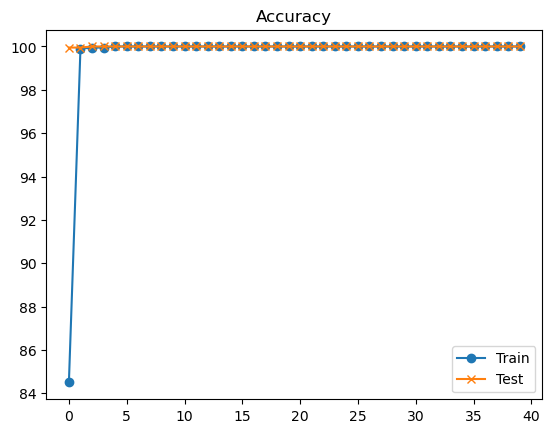

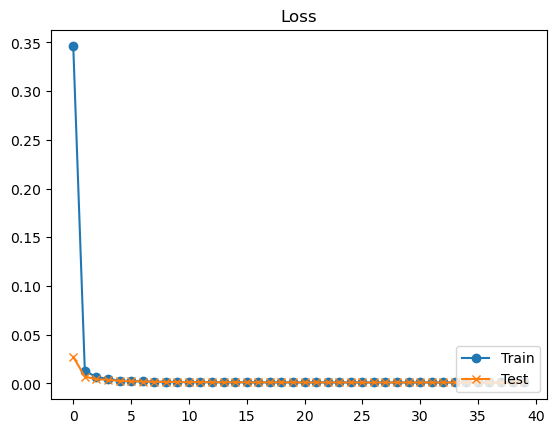

In [17]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
# from tensorflow.keras.losses import BinaryCrossentropyLoss
from tqdm.auto import trange
import matplotlib.pyplot as plt


class FullyConnectedNet(Model):
    def __init__(self, hidden_dim, output_dim, activation='sigmoid'):
        super(FullyConnectedNet, self).__init__()
        self.dense1 = Dense(hidden_dim, activation=activation)
        self.out = Dense(output_dim, activation=activation)
    def call(self,x):
        x = self.dense1(x)
        x = self.out(x)
        return x


def train(model, dataset, loss_obj, num_epochs, optimizer, train_loss, train_accuracy,
    test_dataset, test_loss, test_accuracy, batch_size):
    
    arr_train_loss = np.zeros((num_epochs))
    arr_train_acc = np.zeros((num_epochs))
    arr_test_loss = np.zeros((num_epochs))
    arr_test_acc = np.zeros((num_epochs))
    for epoch in trange(num_epochs):
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()
        for X_data, labels in dataset.shuffle(10000).batch(batch_size):
            with tf.GradientTape() as tape:
                pred = model(X_data, training=True)
                loss = loss_obj(labels, pred)
            
            grad = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grad, model.trainable_variables))

            train_loss(labels, pred)
            train_accuracy(labels, tf.squeeze(pred, axis=1))
        
        arr_train_acc[epoch] = train_accuracy.result() * 100
        arr_train_loss[epoch] = train_loss.result()

        for X_data, labels in test_dataset.shuffle(121345).batch(50):
            pred = model(X_data, training=False)
            loss = loss_obj(labels, pred)

            test_loss(labels, pred)
            test_accuracy(labels, tf.squeeze(pred, axis=1))
        arr_test_acc[epoch] = test_accuracy.result() * 100
        arr_test_loss[epoch] = test_loss.result()

    plt.figure()
    plt.plot(np.arange(num_epochs),arr_train_acc, '-o', label="Train")
    plt.plot(np.arange(num_epochs), arr_test_acc, '-x', label="Test")
    plt.title("Accuracy")
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    plt.plot(np.arange(num_epochs),arr_train_loss, '-o', label="Train")
    plt.plot(np.arange(num_epochs), arr_test_loss, '-x', label="Test")
    plt.title("Loss")
    plt.legend(loc="lower right")
    plt.show()
# def test(model, dataset, loss_obj, num_epochs, optimizer, train_loss, train_accuracy):

def create_square_data():
    num_data = 200
    scale = 0.75
    shift = 0.2
    first_quad_Xdata = scale*np.random.rand(num_data,2) + shift
    first_quad_labels = np.ones(num_data)

    second_quad_Xdata = scale*np.random.rand(num_data,2) + shift
    second_quad_Xdata[:,0] = -second_quad_Xdata[:,0]  
    second_quad_labels = np.ones(num_data)

    third_quad_Xdata = -(scale*np.random.rand(num_data,2) + shift)
    third_quad_labels = np.zeros(num_data)

    fourth_quad_Xdata = scale*np.random.rand(num_data,2) + shift
    fourth_quad_Xdata[:,1] = -fourth_quad_Xdata[:,1] 
    fourth_quad_labels = np.zeros(num_data)
    Xdata = np.concatenate((first_quad_Xdata, second_quad_Xdata,
        third_quad_Xdata, fourth_quad_Xdata), axis=0)
    labels = np.concatenate((first_quad_labels, second_quad_labels,
        third_quad_labels, fourth_quad_labels), axis=0)
    data_set = tf.data.Dataset.from_tensor_slices((Xdata, labels))
    plt.figure()
    plt.scatter(Xdata[:,0], Xdata[:,1])
    plt.show()
    return data_set


lr = ExponentialDecay(1.0, decay_steps=20, decay_rate=0.9, name="exponential_decay_schedule")
batch_size = 64
num_epochs = 40
dtype = tf.float64
model = FullyConnectedNet(2,1,'sigmoid')

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
train_loss = tf.keras.metrics.BinaryCrossentropy()
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
test_loss = tf.keras.metrics.BinaryCrossentropy()
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='binary_accuracy')
training_data = np.loadtxt("training_data.txt")
test_data = np.loadtxt("test_data.txt")
training_data = tf.convert_to_tensor(training_data, dtype=dtype)
test_data = tf.convert_to_tensor(test_data, dtype=dtype)
X_train, y_train = training_data[:,1:], training_data[:,0]
X_test, y_test = training_data[:,1:], training_data[:,0]

train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)
)


test_ds = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)
)

# train_ds = create_square_data()
# test_ds = create_square_data()
train(model, train_ds, loss_object, num_epochs, optimizer, train_loss, train_accuracy, 
    test_ds, test_loss, test_accuracy, batch_size)



The plots above show the accuracy and the loss for train and test data set.
We can see that for this particular run, the accuracy of the training and test data reach 100% after a few epochs. The loss function reach 0 after a few epoch as well. 
The result depends on each run, some of the runs the accuracy peak at 75%. This could be the problem with the data set can be split into a 75% and 25% region. 

One way to visualize the result is to plot the decision boundary and region for the test data set. We will use the code below to show in which region the model decide it is a 1 or 0. The below code is heavily inspire by William Black works. 

<AxesSubplot: xlabel='x', ylabel='y'>

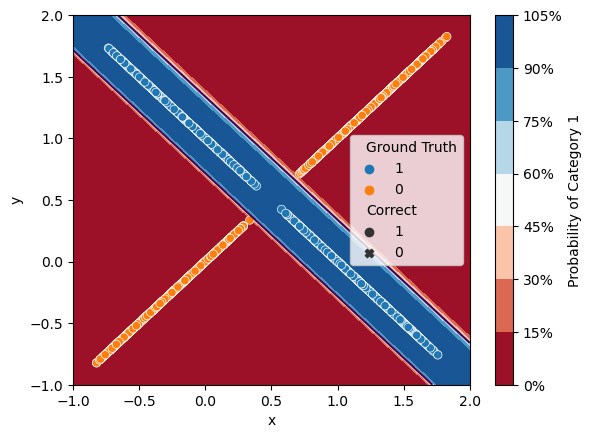

In [18]:
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns

# The plotting of the decision boundary is heavily inspire by
# William Black, with the great usage of seaborn library
pred = tf.cast(model(X_test) > 0.5, tf.dtypes.uint8)
y_test = tf.cast(tf.reshape(y_test, (-1, 1)), tf.dtypes.uint8)

df = pd.DataFrame(
    data={
        "x": X_test[:, 0],
        "y": X_test[:, 1],
        "Ground Truth": pd.Series(tf.reshape(y_test, (-1,))),
        "Prediction": pd.Series(tf.reshape(pred, (-1,))),
        "Correct": pd.Series(tf.reshape(y_test == pred, (-1,)), dtype=int),
    },
)
xlim = (-1, 2)
ylim = (-1, 2)
N_h_gridpoints = 100 * (xlim[1] - xlim[0])
N_v_gridpoints = 100 * (ylim[1] - ylim[0])

hmesh = np.linspace(*xlim, num=N_h_gridpoints)
vmesh = np.linspace(*ylim, num=N_v_gridpoints)

xgrid, ygrid = np.meshgrid(hmesh, vmesh)

onehotx, onehoty = xgrid.reshape((-1, 1)), ygrid.reshape((-1, 1))

onehotgrid = np.hstack((onehotx, onehoty))

onehotgridpred = model(onehotgrid)

gridpred = tf.reshape(onehotgridpred, xgrid.shape)

cf = plt.contourf(
    xgrid,
    ygrid,
    gridpred,
    cmap="RdBu",
)
plt.colorbar(
    cf,
    label="Probability of Category 1",
    spacing="proportional",
    format=PercentFormatter(xmax=1),
)

plt.contour(
    xgrid,
    ygrid,
    gridpred,
    levels=[0.5],
)
sns.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="Ground Truth",
    hue_order=[1, 0],
    style="Correct",
    style_order=[1, 0],
)


From this plot, we can see that the model decision region match with the test data, where there is a blue stripe in the diagonal, and the remaining region is read. The decision regions are run dependend. Sometime there is a red stripe instead of blue in the other diagional. And sometime, it divides the plot by half on the diagonal where they will predict 75% of the data correctly. 